# LSTM Model

In [14]:
import pandas as pd 
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
from math import sqrt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM ,Dense
from tensorflow.keras.utils import plot_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler


# Load and PreProcess 

In [15]:
loaded = np.load('data/pems08.npz')
sets = loaded.f.data
print(sets.shape)

(17856, 170, 3)


In [16]:
def get_data(road, features):
    datax = sets[:,0,:features]
    if road <=170:
        for k in range(1,road):
            datax = np.concatenate((datax ,sets[:,k,:features]))
    return datax

In [17]:
dataOG = get_data(1,2)
print(dataOG.shape)

(17856, 2)


In [18]:
# Load the data
dataBefore = dataOG[:,0].reshape(-1,1)

# Normalize the data
scaler = MinMaxScaler()
data = scaler.fit_transform(dataBefore)

In [19]:
# Split the data into training and testing sets
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train_data, test_data = data[0:train_size,:], data[train_size:len(data),:]


In [20]:
# Create sequences of data
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data)-seq_length-1):
        x.append(data[i:(i+seq_length), 0])
        y.append(data[i+seq_length, 0])
    return np.array(x), np.array(y)

seq_length = 30
trainX, trainY = create_sequences(train_data, seq_length)
testX, testY = create_sequences(test_data, seq_length)

# Reshape the data for the LSTM model
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))


# 1 features model

In [21]:
# Define the model architecture
model = Sequential([
    LSTM(64, input_shape=(seq_length, 1),return_sequences=True, unit_forget_bias=True),
    LSTM(32,return_sequences=True),
    LSTM(64,return_sequences=False),
    Dense(1)
])

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')


# Train & Predict

In [22]:
# Train the model
model.fit(trainX, trainY, epochs=20, batch_size=64, validation_data=(testX, testY))

# Make predictions on the test data
testPredict = model.predict(testX)

Epoch 1/20
223/223 [==============================] - 17s 52ms/step - loss: 0.0097 - val_loss: 0.0040
Epoch 2/20
223/223 [==============================] - 10s 43ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 3/20
223/223 [==============================] - 10s 45ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 4/20
223/223 [==============================] - 10s 44ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 5/20
223/223 [==============================] - 10s 43ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 6/20
223/223 [==============================] - 10s 43ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 7/20
223/223 [==============================] - 9s 42ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 8/20
223/223 [==============================] - 9s 42ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 9/20
223/223 [==============================] - 10s 43ms/step - loss: 0.0018 - val_loss: 0.0026
Epoch 10/20
223/223 [==============================] - 9s 42ms/step - loss: 0.0018 -

# Result

In [23]:
# Inverse transform the predictions and actual values
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Calculate root mean squared error
rmse = sqrt(mean_squared_error(testY[0],testPredict.reshape(-1,1)))

# Calculate R2 score
testYshape=testY.reshape(len(testY[0]),1)
r2s = r2_score(y_true=testYshape,y_pred=testPredict)

print('Test RMSE: %.2f' % rmse)
print('Test R2: %.2f' % r2s)

Test RMSE: 28.61
Test R2: 0.96


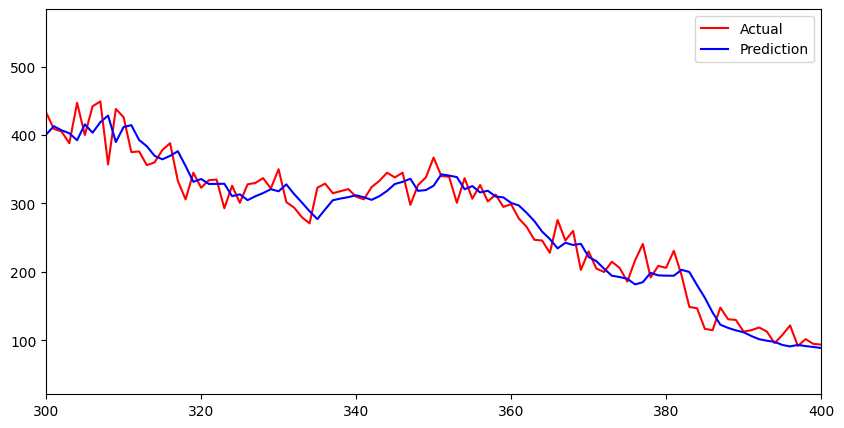

In [26]:
plt.figure(figsize=(10,5))
plt.plot(testYshape,color = 'red',label = 'Actual')
plt.plot(testPredict,color = 'blue',label = 'Prediction')
plt.legend()
plt.xlim(300,400)
plt.show()

In [25]:
plot_model(model, to_file='model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=False,
    rankdir='LR',
    expand_nested=True,
    dpi=80,
    layer_range=None,
    show_layer_activations=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# 2 features

# Load the data
data = pd.read_csv('data/PMS_data.csv',nrows=100000)

# Extract the features you want to use
data = data[['Flow', 'Occupy']]

# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Split the data into training and testing sets
train_size = int(len(data_scaled) * 0.8)
train_data, test_data = data_scaled[0:train_size], data_scaled[train_size:]
print(train_data.shape[1])

def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data)-seq_length-1):
        # Extract two features (traffic volume and temperature)
        feature1 = data[i:(i+seq_length), 0]
        feature2 = data[i:(i+seq_length), 1]
        x.append(np.column_stack((feature1, feature2)))
        y.append(data[i+seq_length, 0])
    return np.array(x), np.array(y)
seq_length = 30
trainX, trainY = create_sequences(train_data, seq_length)
testX, testY = create_sequences(test_data, seq_length)

# Define the LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(loss='mse', optimizer='adam')

# Fit the model
history = model.fit(trainX, trainY, epochs=50, batch_size=72, validation_data=(testX, testY), verbose=2, shuffle=False)
